In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import reduce_mem_usage
#from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgbm 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error
#%load_ext nb_black
import joblib
import seaborn as sns
#from loguru import logger

In [3]:
def read_data():
    sales = pd.read_csv("sales_train_evaluation.csv")
    calendar = pd.read_csv("calendar.csv")
    prices = pd.read_csv("sell_prices.csv")
    submission = pd.read_csv("sample_submission.csv")

    #     sales = reduce_mem_usage(sales)
    #     calendar = reduce_mem_usage(calendar)
    #     prices = reduce_mem_usage(prices)
    #     submission = reduce_mem_usage(submission)

    return sales, calendar, prices, submission

In [4]:
sales, calendar, prices, submission = read_data()

In [5]:
def create_shifted_feature(
    data: pd.DataFrame,
    lag: int = 28,
    feature_col: str = "sales",
    id_col: str = "id",
) -> pd.DataFrame:
    feat = data.groupby(id_col)[feature_col].shift(-lag).fillna(0)
    return feat


def preprocess_calendar(calendar: pd.DataFrame) -> pd.DataFrame:
    calendar = calendar.copy()
    event_name_map = {mod: i for i, mod in enumerate(calendar["event_name_1"].unique())}
    event_type_map = {mod: i for i, mod in enumerate(calendar["event_type_1"].unique())}

    calendar["event_name"] = calendar["event_name_1"]
    calendar["event_type"] = calendar["event_type_1"]

    calendar["event_name"] = calendar["event_name"].map(event_name_map)
    calendar["event_type"] = calendar["event_type"].map(event_type_map)
    calendar["d"] = calendar["d"].str.replace("d_", "").astype(int)
    calendar["date"] = pd.to_datetime(calendar["date"])
    calendar["wday"] -= 1
    calendar["month"] -= 1
    calendar["year"] -= 2011

    calendar = calendar.sort_values("date")
    calendar = calendar.drop(
        [
            "event_name_1",
            "event_name_2",
            "event_type_1",
            "event_type_2",
            "date",
            "weekday",
        ],
        axis=1,
    )
    return calendar


def preprocess_sales(sales):
    sales = sales.copy()
    series_cols = sales.columns[sales.columns.str.contains("d_")].values
    level_cols = sales.columns[~sales.columns.str.contains("d_")].values
    sales = sales.melt(level_cols, series_cols, var_name="day", value_name="sales")
    sales["day"] = sales["day"].str.replace("d_", "").astype(int)
    return sales


def merge_and_melt(sales, calendar, prices):
    #logger.info("preprocessing")
    sales = preprocess_sales(sales)
    calendar = preprocess_calendar(calendar)

    #logger.info("merging with calendar, prices")
    # merge with calendar
    sales = sales.merge(
        calendar, left_on="day", right_on="d", validate="many_to_one", how="left"
    )
    sales = sales.merge(
        prices,
        left_on=["item_id", "store_id", "wm_yr_wk"],
        right_on=["item_id", "store_id", "wm_yr_wk"],
        validate="many_to_one",
        how="left",
    )
    return sales


def intervaled_cumsum(a, trigger_val=1, start_val=0, invalid_specifier=-1):
    out = np.ones(a.size, dtype=int)
    idx = np.flatnonzero(a == trigger_val)
    if len(idx) == 0:
        return np.full(a.size, invalid_specifier)
    else:
        out[idx[0]] = -idx[0] + 1
        out[0] = start_val
        out[idx[1:]] = idx[:-1] - idx[1:] + 1
        np.cumsum(out, out=out)
        out[: idx[0]] = invalid_specifier
        return out


def feature_engineering(sales: pd.DataFrame) -> pd.DataFrame:

    #logger.info("feature engineeering")
    # impute missing data on sell price
    sales["sell_price"] = sales.groupby("item_id")["sell_price"].apply(
        lambda x: x.fillna(x[~x.isnull()].median())
    )

    # make rolling averages/std for items
    windows = [3, 7, 30, 90, 180, 360]
    for window in tqdm(windows, desc="fe: rolling stats"):
        sales.loc[:, f"rolling_sales_mean_{window}"] = (
            sales.groupby(["id"])["sales"]
            .transform(lambda x: x.rolling(window=window).mean())
            .astype(np.float16)
            .fillna(0)
        )
        sales.loc[:, f"rolling_sales_std_{window}"] = (
            sales.groupby(["id"])["sales"]
            .transform(lambda x: x.rolling(window=window).std())
            .astype(np.float16)
            .fillna(0)
        )

    # difference between short-long trends
    short_windows = [3, 7, 30]
    long_windows = [90, 180, 360]

    for short_window in tqdm(short_windows, desc="fe: long-short term diff"):
        for long_window in long_windows:
            sales.loc[:, f"trend_diff_{short_window}_{long_window}"] = (
                sales[f"rolling_sales_mean_{short_window}"]
                - sales[f"rolling_sales_mean_{long_window}"]
            )

    # store-wise rolling average

    # see if in a zero plateau
    sustained_zero = (
        sales.groupby("id")["sales"]
        .apply(lambda x: intervaled_cumsum(x == 0))
        .explode()
        .astype(int)
    )
    sustained_zero.name = "days_sustained_zero"
    sustained_zero = sustained_zero.reset_index()
    sustained_zero.loc[:, "day"] = sustained_zero.groupby("id").transform(
        lambda x: np.arange(len(x)) + 1
    )

    sales = sales.merge(sustained_zero, on=["id", "day"], how="left", copy=False)

    # create target variable
    aheads = [1, 7, 28]
    for ahead in tqdm(aheads, desc="fe: ahead target"):
        y_ahead = create_shifted_feature(sales, ahead)
        sales.loc[:, f"target_shift_{ahead}"] = y_ahead

    # shift future events back
    for ahead in tqdm(aheads, desc="fe: ahead events"):
        event_type_ahead = create_shifted_feature(
            sales, ahead, feature_col="event_type"
        )
        sales.loc[:, f"event_type_shift_{ahead}"] = event_type_ahead
    #         event_name = create_shifted_feature(
    #             sales,
    #             lage,
    #             feature_col="event_name"
    #         )

    return sales


In [31]:
# data_saved = os.path.isfile("../data/train.h5")
data_saved = True

if data_saved:
    data = pd.read_hdf("train2.h5")
else:
    data = merge_and_melt(sales, calendar, prices)
    data = feature_engineering(data)
    data = reduce_mem_usage(data)

    data.to_hdf("train2.h5", key="train", format="table")

In [32]:
ahead_by = 28

assert ahead_by in [1, 7, 28]

dump_cols = ["id", "wm_y_wk", "event_name"] + [
    c for c in data.columns if c.startswith("target") or c.startswith("event")
]
feat_col = [c for c in data.columns if c not in dump_cols] + [
    f"event_type_shift_{ahead_by}"
]
target_col = f"target_shift_{ahead_by}"

In [10]:
data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'sales', 'wm_yr_wk', 'wday', 'month', 'year', 'd', 'snap_CA', 'snap_TX',
       'snap_WI', 'event_name', 'event_type', 'sell_price',
       'rolling_sales_mean_3', 'rolling_sales_std_3', 'rolling_sales_mean_7',
       'rolling_sales_std_7', 'rolling_sales_mean_30', 'rolling_sales_std_30',
       'rolling_sales_mean_90', 'rolling_sales_std_90',
       'rolling_sales_mean_180', 'rolling_sales_std_180',
       'rolling_sales_mean_360', 'rolling_sales_std_360', 'trend_diff_3_90',
       'trend_diff_3_180', 'trend_diff_3_360', 'trend_diff_7_90',
       'trend_diff_7_180', 'trend_diff_7_360', 'trend_diff_30_90',
       'trend_diff_30_180', 'trend_diff_30_360', 'days_sustained_zero',
       'target_shift_1', 'target_shift_7', 'target_shift_28',
       'event_type_shift_1', 'event_type_shift_7', 'event_type_shift_28'],
      dtype='object')

In [11]:
data.isnull().sum().sort_values(ascending=False).head(20)

days_sustained_zero       59181090
id                               0
trend_diff_7_180                 0
rolling_sales_std_90             0
rolling_sales_mean_180           0
rolling_sales_std_180            0
rolling_sales_mean_360           0
rolling_sales_std_360            0
trend_diff_3_90                  0
trend_diff_3_180                 0
trend_diff_3_360                 0
trend_diff_7_90                  0
trend_diff_7_360                 0
rolling_sales_std_30             0
trend_diff_30_90                 0
trend_diff_30_180                0
trend_diff_30_360                0
target_shift_1                   0
target_shift_7                   0
target_shift_28                  0
dtype: int64

# Model

## linear model

### use d_1 to d_1885 to forcast next 28 day (For validation)

In [12]:
cat_features=["item_id", "dept_id","cat_id","store_id","state_id"]
encoder_list = []
for i in cat_features:
    encoder = preprocessing.LabelEncoder()
    encoder.fit(data[i])
    data[i] = encoder.transform(data[i])
    encoder_list.append(encoder)

In [15]:

train = data[data['day']<=1885]
val = data[(data['day']>=1886) & (data['day']<=1913)]

feat_col.remove('days_sustained_zero')

X_train, y_train = train[feat_col], train[target_col]
X_val, y_val = val[feat_col], val[target_col]

In [16]:
liner_clf = LinearRegression()
liner_clf.fit(X_train, y_train)

LinearRegression()

In [17]:
pre_val_y = liner_clf.predict(X_val)

In [18]:
mean_squared_error(y_val, pre_val_y, squared=False)

2.239601776021867

In [19]:
joblib.dump(liner_clf, 'liner_clf_val2.pth')

['liner_clf_val2.pth']

In [20]:
val_resutl = val.copy()
val_resutl = val_resutl[['id', 'day', 'sales']]
val_resutl = pd.pivot(val_resutl, index = 'id', columns = 'day', values = 'sales').reset_index()
val_resutl.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [21]:
pre_resutl = val.copy()
pre_resutl = pre_resutl[['id', 'day', 'sales']]
pre_resutl['sales'] = pre_val_y
pre_resutl = pd.pivot(pre_resutl, index = 'id', columns = 'day', values = 'sales').reset_index()
pre_resutl.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

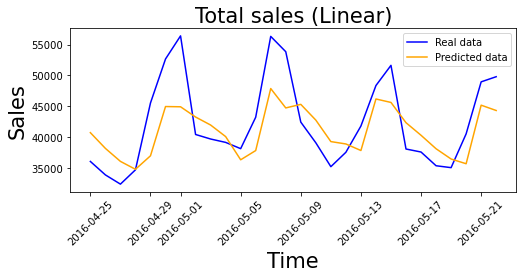

In [22]:
x1 = pd.date_range(start="2016-04-25",end="2016-5-22")
#x2 = pd.date_range(start="2011-01-29",end="2016-04-24)
#y1 = np.append(np.array(raw_data[-1:]), real_new_case)
#y2 = np.append(np.array(raw_data[-1:]), result_rev)
y1 = np.array(val_resutl.sum())
y2 = np.array(pre_resutl.sum())

fig = plt.figure(figsize=(16,6))
plt.plot(x1, y1, color = 'blue', label = 'Real data')
#plt.plot(x2,np.array(raw_data[-30:]), color = 'orange', label = 'Real data')
plt.title('Total sales (Linear)',fontsize = 21)
plt.plot(x1, y2, color = 'orange', label = 'Predicted data')

plt.xlabel('Time',fontsize = 21)
plt.ylabel('Sales',fontsize = 21)
plt.legend()
plt.xticks(rotation=45)
plt.savefig('liner_pre.png')

### use d_1 to d_1941 to forcast next 28 day

In [127]:
cat_features=["item_id", "dept_id","cat_id","store_id","state_id"]
encoder_list = []
for i in cat_features:
    encoder = preprocessing.LabelEncoder()
    encoder.fit(data[i])
    data[i] = encoder.transform(data[i])
    encoder_list.append(encoder)

In [23]:
train = data[data['day']<1914]
val = data[(data['day']>=1914) & (data['day']<1942)]
test = data[data['day']>=1942]


In [129]:
feat_col.remove('days_sustained_zero')

In [24]:
X_train, y_train = train[feat_col], train[target_col]
X_val, y_val = val[feat_col], val[target_col]
X_test, y_test = test[feat_col], test[target_col]

In [25]:
liner_clf = LinearRegression()
liner_clf.fit(X_train, y_train)

LinearRegression()

In [26]:
joblib.dump(liner_clf, 'liner_clf2.pth')

['liner_clf2.pth']

In [27]:
pre_y = liner_clf.predict(X_val)

In [28]:
evaluation_result = val.copy()
evaluation_result = evaluation_result[['id', 'day', 'sales']]
evaluation_result['sales'] = pre_y
evaluation_result = pd.pivot(evaluation_result, index = 'id', columns = 'day', values = 'sales').reset_index()
evaluation_result.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [29]:
val_resutl = val.copy()
val_resutl = val_resutl[['id', 'day', 'sales']]
val_resutl['id'] = val_resutl['id'].str.replace("evaluation", "validation")
val_resutl = pd.pivot(val_resutl, index = 'id', columns = 'day', values = 'sales').reset_index()
val_resutl.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [30]:
final_result = pd.concat([val_resutl, evaluation_result])

final_result.to_csv('result2_linear.csv',index=False)

# LGBM

### use d_1 to d_1885 to forcast next 28 day (For validation)

In [33]:
cat_features=["item_id", "dept_id","cat_id","store_id","state_id"]

In [34]:

train = data[data['day']<=1885]
val = data[(data['day']>=1886) & (data['day']<=1913)]

X_train, y_train = train[feat_col], train[target_col]
X_val, y_val = val[feat_col], val[target_col]

y_val_preds = np.zeros(val.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = feat_col



In [35]:
# setup model setting
fold_num = 3
seed = 501
kf = StratifiedKFold(n_splits= fold_num, shuffle=True, random_state=seed)


params = {'num_leaves': 100,
          'max_depth': 9,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          'objective': 'regression',
          "metric": 'rmse',
          'reg_alpha': 0.2,
          'reg_lambda': 0.2,
          'subsample': 0.6,
          'categorical_feature': cat_features,
          'min_split_gain': 0.02,
          
         }

In [36]:

for fold, (train_set, val_set) in enumerate(kf.split(X_train,y_train)):
    
    train_x, train_y = X_train.iloc[train_set], y_train.iloc[train_set]
    train_dataset = lgbm.Dataset(train_x, label=train_y)
    val_x, val_y = X_train.iloc[val_set], y_train.iloc[val_set]
    val_dataset = lgbm.Dataset(val_x, label=val_y)
    

    lgbm_model = lgbm.train(params, train_dataset, 300, valid_sets=[train_dataset,val_dataset], verbose_eval= 100, early_stopping_rounds= 100)
    feature_importances[f'fold_{fold + 1}'] = lgbm_model.feature_importance()
    
    y_val_preds += lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)/fold_num
    
    

    




/Users/ericlo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/ericlo/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:840: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'
/Users/ericlo/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.3323	valid_1's rmse: 2.35471
[200]	training's rmse: 2.26192	valid_1's rmse: 2.29843
[300]	training's rmse: 2.22494	valid_1's rmse: 2.27088
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 2.22494	valid_1's rmse: 2.27088
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.33576	valid_1's rmse: 2.35979
[200]	training's rmse: 2.26302	valid_1's rmse: 2.30209
[300]	training's rmse: 2.22694	valid_1's rmse: 2.27543
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 2.22694	valid_1's rmse: 2.27543
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.33229	valid_1's rmse: 2.3584
[200]	training's rmse: 2.26321	valid_1's rmse: 2.30183
[300]	training's rmse: 2.22583	valid_1's rmse: 2.27307
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 2.22583	valid_1's rmse: 2.27307


In [44]:
feature_importances['mean'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(fold_num)]].mean(axis=1)
feature_importances['mean_normalized'] = feature_importances['mean']/feature_importances['mean'].sum()
feature_importances.to_csv('feature_importances.csv')

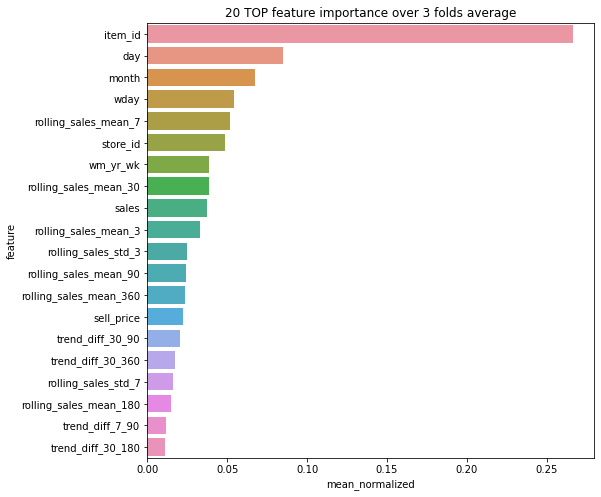

In [70]:
plt.figure(figsize=(8, 8))
sns.barplot(data=feature_importances.sort_values(by='mean_normalized', ascending=False).head(20), x='mean_normalized', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(fold_num))
plt.savefig('feature_importances.png')

In [46]:
mean_squared_error(y_val, y_val_preds, squared=False)

2.167525715911492

In [47]:
lgbm_model.save_model('lgbm_model_val2.txt')

In [67]:
val_resutl = val.copy()
val_resutl = val_resutl[['id', 'day', 'sales']]
val_resutl = pd.pivot(val_resutl, index = 'id', columns = 'day', values = 'sales').reset_index()
val_resutl.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [68]:
pre_resutl = val.copy()
pre_resutl = pre_resutl[['id', 'day', 'sales']]
pre_resutl['sales'] = y_val_preds
pre_resutl = pd.pivot(pre_resutl, index = 'id', columns = 'day', values = 'sales').reset_index()
pre_resutl.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

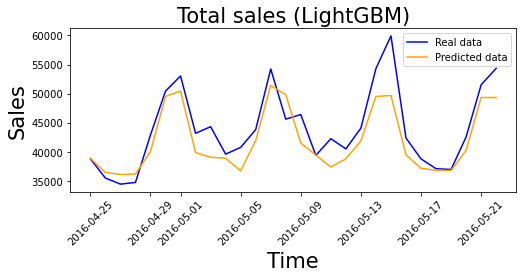

In [69]:
x1 = pd.date_range(start="2016-04-25",end="2016-5-22")
#x2 = pd.date_range(start="2011-01-29",end="2016-04-24)
#y1 = np.append(np.array(raw_data[-1:]), real_new_case)
#y2 = np.append(np.array(raw_data[-1:]), result_rev)
y1 = np.array(val_resutl.sum())
y2 = np.array(pre_resutl.sum())

fig = plt.figure(figsize=(8,3))
plt.plot(x1, y1, color = 'blue', label = 'Real data')
#plt.plot(x2,np.array(raw_data[-30:]), color = 'orange', label = 'Real data')
plt.title('Total sales (LightGBM)',fontsize = 21)
plt.plot(x1, y2, color = 'orange', label = 'Predicted data')

plt.xlabel('Time',fontsize = 21)
plt.ylabel('Sales',fontsize = 21)
plt.legend()
plt.xticks(rotation=45)
plt.savefig('lgbm_total_sales.png')

### use d_1 to d_1941 to forcast next 28 day 

In [92]:
cat_features=["item_id", "dept_id","cat_id","store_id","state_id"]

In [51]:
train = data[data['day']<1914]
val = data[(data['day']>=1914) & (data['day']<1942)]
test = data[data['day']>=1942]
X_train, y_train = train[feat_col], train[target_col]
X_val, y_val = val[feat_col], val[target_col]
X_test, y_test = test[feat_col], test[target_col]

In [52]:
# setup model setting
fold_num = 3
seed = 501
kf = StratifiedKFold(n_splits= fold_num, shuffle=True, random_state=seed)


In [53]:

params = {'num_leaves': 100,
          'max_depth': 9,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          'objective': 'regression',
          "metric": 'rmse',
          'reg_alpha': 0.2,
          'reg_lambda': 0.2,
          'subsample': 0.6,
          'categorical_feature': cat_features,
          'min_split_gain': 0.02,
          
         }

In [54]:
y_preds = np.zeros(val.shape[0])

for fold, (train_set, val_set) in enumerate(kf.split(X_train,y_train)):
    
    train_x, train_y = X_train.iloc[train_set], y_train.iloc[train_set]
    train_dataset = lgbm.Dataset(train_x, label=train_y)
    val_x, val_y = X_train.iloc[val_set], y_train.iloc[val_set]
    val_dataset = lgbm.Dataset(val_x, label=val_y)
    

    lgbm_model = lgbm.train(params, train_dataset, 300, valid_sets=[train_dataset,val_dataset], verbose_eval= 100, early_stopping_rounds= 100)

    y_preds += lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)/fold_num
    
    

    



/Users/ericlo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/ericlo/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:840: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'
/Users/ericlo/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.33087	valid_1's rmse: 2.36056
[200]	training's rmse: 2.25868	valid_1's rmse: 2.30318
[300]	training's rmse: 2.22218	valid_1's rmse: 2.27609
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 2.22218	valid_1's rmse: 2.27609
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.33301	valid_1's rmse: 2.35184
[200]	training's rmse: 2.26285	valid_1's rmse: 2.29489
[300]	training's rmse: 2.22548	valid_1's rmse: 2.26767
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 2.22548	valid_1's rmse: 2.26767
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.33084	valid_1's rmse: 2.35286
[200]	training's rmse: 2.26098	valid_1's rmse: 2.29526
[300]	training's rmse: 2.22406	valid_1's rmse: 2.26676
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 2.22406	valid_1's rmse: 2.26676


In [61]:
lgbm_model.save_model('lgbm_model2.txt')

In [62]:
y_preds

array([0.75351872, 0.28130571, 0.51971678, ..., 0.91291922, 1.45875065,
       2.06647276])

In [63]:
evaluation_result = val.copy()
evaluation_result = evaluation_result[['id', 'day', 'sales']]
evaluation_result['sales'] = y_preds
evaluation_result = pd.pivot(evaluation_result, index = 'id', columns = 'day', values = 'sales').reset_index()
evaluation_result.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [64]:
val_resutl = val.copy()
val_resutl = val_resutl[['id', 'day', 'sales']]
val_resutl['id'] = val_resutl['id'].str.replace("evaluation", "validation")
val_resutl = pd.pivot(val_resutl, index = 'id', columns = 'day', values = 'sales').reset_index()
val_resutl.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [65]:
final_result = pd.concat([val_resutl, evaluation_result])

final_result.to_csv('result2_lgbm.csv',index=False)

In [66]:
evaluation_result

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.909674,0.828633,0.791910,0.755656,0.774492,0.990968,0.961038,0.725952,1.018989,...,0.824227,1.175740,1.162344,0.828088,0.760026,0.704647,0.715701,0.735859,0.862227,0.824878
1,FOODS_1_001_CA_2_evaluation,0.991605,1.068320,0.974023,0.920026,0.946365,1.266698,1.451209,1.033386,0.980943,...,1.000778,1.263384,1.243069,0.965161,0.829450,0.805190,0.778418,0.829946,1.072391,1.004821
2,FOODS_1_001_CA_3_evaluation,0.861007,0.819222,0.849241,0.824701,1.400823,1.478222,1.463371,1.065438,1.088379,...,0.906073,1.205908,1.349910,0.976777,0.845464,0.875908,0.857050,1.076372,1.279559,1.314690
3,FOODS_1_001_CA_4_evaluation,0.315325,0.342129,0.304358,0.304358,0.305273,0.318837,0.364642,0.298062,0.291830,...,0.338482,0.333077,0.334097,0.269917,0.259953,0.275437,0.295096,0.308875,0.327195,0.294105
4,FOODS_1_001_TX_1_evaluation,0.423935,0.416462,0.502392,0.482303,0.554112,0.588456,0.643653,0.561452,0.576073,...,0.611069,0.679695,0.665672,0.569134,0.842691,0.768244,0.858703,0.969897,1.063356,1.145227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.233527,0.215004,0.157539,0.154932,0.171064,0.194403,0.194843,0.241133,0.220934,...,0.232265,0.186476,0.187465,0.245465,0.212805,0.212805,0.194536,0.219205,0.245466,0.310372
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.113020,0.108836,0.108836,0.101332,0.130709,0.131207,0.230351,0.174949,0.172612,...,0.187868,0.241362,0.223657,0.184905,0.160950,0.160950,0.160950,0.223564,0.256064,0.434519
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.159578,0.141447,0.141447,0.172045,0.186640,0.248455,0.218312,0.122304,0.120630,...,0.182734,0.159174,0.156950,0.107685,0.103688,0.103688,0.103688,0.199818,0.232624,0.228458
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.136052,0.132055,0.132055,0.100943,0.123789,0.118493,0.115583,0.099064,0.098027,...,0.119969,0.110753,0.200672,0.195196,0.177064,0.168848,0.147050,0.170545,0.181597,0.155391
